In [31]:
import numpy as np

#data = np.genfromtxt("MayoTrain13k.csv",delimiter=',')
#Dev = np.genfromtxt("MayoVal13k.csv",delimiter=',')
data = np.genfromtxt("NEPCMayoTrain.csv",delimiter=',')
Dev = np.genfromtxt("NEPCMayoVal.csv",delimiter=',')
W_pros = np.genfromtxt("W.csv",delimiter=',')
#Test = np.genfromtxt("RPCL01RPTest.csv",delimiter=',')
#Dev = np.genfromtxt("RPCL01RPDev.csv",delimiter=',')
print(np.shape(data))
print(np.shape(Dev))
print(np.shape(W_pros))

(338, 13856)
(186, 13856)
(13856, 256)


In [44]:
from __future__ import with_statement
from __future__ import division
from __future__ import absolute_import
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

n_hiddenF = 256
n_hidden = 64

def PlaceH(n_input): 
    x = tf.placeholder(u"float", [None, n_input])
    y_ = tf.placeholder(u"float", [None,n_input])
    return x, y_

def corruption(input, corruption_level): #corruption of the input
    mask=np.random.binomial(1, 1 - corruption_level,input.shape ) #mask with several zeros at certain position
    corrupted_input=input*mask
    return corrupted_input

def Initializarion(n_hiddenF, n_hidden, n_samp):
    Wh = tf.Variable(tf.random_uniform((n_hiddenF, n_hidden), -4.0* math.sqrt(6/(n_hiddenF + n_hidden)), 
                                        4.0* math.sqrt(6/(n_hidden + n_hiddenF))))
    bh = tf.Variable(tf.zeros([n_hidden]))     
    Wo = tf.transpose(Wh) # tied weights
    bo = tf.Variable(tf.zeros([n_hiddenF]))
    W = tf.Variable(initial_value = W_pros, trainable = False)
    #W = tf.Variable(tf.random_uniform((13856, 256), -4.0* math.sqrt(6/(13856 + 256)), 
    #                                    4.0* math.sqrt(6/(13856 + 256))))
    W_o = tf.transpose(W)
    return Wh, bh, Wo, bo, W, W_o

def EnLoad(dat, W):
    #W = tf.cast(W , tf.float32)
    En_dat = tf.nn.sigmoid(tf.matmul(dat,W))
    return En_dat

def DeLoad(W_o, ho):
    #Fr_TW = tf.transpose(W)
    #W_o = tf.cast(W_o, tf.float32)
    #Fr_Tb = Fr_b
    De_dat = tf.nn.sigmoid(tf.matmul(ho, W_o))
    return De_dat

def AE(dat, Wh, Wo, bh, bo, W, W_o): 
    W = tf.cast(W , tf.float32)
    W_o = tf.cast(W_o, tf.float32)
    En_dat = tf.nn.sigmoid(tf.matmul(dat,W))
    h = tf.nn.sigmoid(tf.matmul(En_dat,Wh) + bh)
    h2o = tf.nn.sigmoid(tf.matmul(h, Wo) + bo)
    ho = tf.nn.sigmoid(tf.matmul(h2o, W_o))
    return h, ho

def KF(dat, k):
    kf = KFold(n_splits=k)
    kf.get_n_splits(dat)
    return kf.split(dat)

def compute_cost(Z, y_):
    logits = Z
    labels = y_    
    cost = tf.reduce_mean(tf.losses.mean_squared_error (predictions = logits , labels = labels))    
    return cost

def random_mini_batches(X, Y, mini_batch_size = 10, seed = 42):    
    np.random.seed(seed)            
    m = X.shape[0]                  
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X
    shuffled_Y = Y

    num_complete_minibatches = math.floor(m/mini_batch_size)
    
    #print(type(num_complete_minibatches))
    
    for k in xrange(0, int(num_complete_minibatches)):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    Lower = int(num_complete_minibatches * mini_batch_size)
    Upper = int(m - (mini_batch_size * math.floor(m/mini_batch_size)))

    if m % mini_batch_size != 0:
        mini_batch_X = X[Lower : Lower + Upper, :]
        mini_batch_Y = Y[Lower : Lower + Upper, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches, permutation

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 10, minibatch_size = 10, print_cost = True):
    seed = 0 
    tf.set_random_seed(seed)    
    (n_samp, n_input) = X_train.shape                         
    costs = []                                        
    
    X, Y = PlaceH(n_input)

    Wh, bh, Wo, bo, W, W_o = Initializarion(n_hiddenF, n_hidden, n_samp)
    
    #En_X = EnLoad(X, W)
    H, Z = AE(X, Wh, Wo, bh, bo, W, W_o)
    #Z = DeLoad(W_o, Ho)
    
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in xrange(num_epochs):

            epoch_cost = 0.                     
            num_minibatches = int(n_samp / minibatch_size) 
            seed = seed + 1
            minibatches, permutation = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost = epoch_cost + (minibatch_cost / num_minibatches)

            print u"Cost after epoch %i: %f" % (epoch, epoch_cost)
            costs.append(np.mean(epoch_cost))
                
        plt.plot(np.squeeze(costs))
        plt.ylabel(u'cost')
        plt.xlabel(u'iterations (per tens)')
        plt.title(u"Learning rate =" + unicode(learning_rate))
        plt.show()
        
        Weight = sess.run(Wh, feed_dict={X: X_train, Y: Y_train})
        bias = sess.run(bh, feed_dict={X: X_train, Y: Y_train})
        Hidden = sess.run(H, feed_dict={X: X_train, Y: Y_train})
        Y_hat = sess.run(Z, feed_dict={X: X_train, Y: Y_train})
        ts_cost = cost.eval({X: X_test, Y: Y_test})
        print u"Test cost:", ts_cost  
        print u"Parameters have been trained!"
        return Weight, bias, Hidden, Y_hat, costs, ts_cost, permutation 


Cost after epoch 0: 0.269011
Cost after epoch 1: 0.268824
Cost after epoch 2: 0.268637
Cost after epoch 3: 0.268452
Cost after epoch 4: 0.268267
Cost after epoch 5: 0.268084
Cost after epoch 6: 0.267902
Cost after epoch 7: 0.267721
Cost after epoch 8: 0.267542
Cost after epoch 9: 0.267363
Cost after epoch 10: 0.267186
Cost after epoch 11: 0.267010
Cost after epoch 12: 0.266835
Cost after epoch 13: 0.266662
Cost after epoch 14: 0.266489
Cost after epoch 15: 0.266318
Cost after epoch 16: 0.266148
Cost after epoch 17: 0.265979
Cost after epoch 18: 0.265811
Cost after epoch 19: 0.265645
Cost after epoch 20: 0.265479
Cost after epoch 21: 0.265315
Cost after epoch 22: 0.265151
Cost after epoch 23: 0.264989
Cost after epoch 24: 0.264828
Cost after epoch 25: 0.264667
Cost after epoch 26: 0.264508
Cost after epoch 27: 0.264350
Cost after epoch 28: 0.264193
Cost after epoch 29: 0.264037
Cost after epoch 30: 0.263881
Cost after epoch 31: 0.263727
Cost after epoch 32: 0.263574
Cost after epoch 33:

Cost after epoch 268: 0.248177
Cost after epoch 269: 0.248154
Cost after epoch 270: 0.248132
Cost after epoch 271: 0.248109
Cost after epoch 272: 0.248087
Cost after epoch 273: 0.248065
Cost after epoch 274: 0.248043
Cost after epoch 275: 0.248021
Cost after epoch 276: 0.247999
Cost after epoch 277: 0.247977
Cost after epoch 278: 0.247955
Cost after epoch 279: 0.247933
Cost after epoch 280: 0.247912
Cost after epoch 281: 0.247890
Cost after epoch 282: 0.247868
Cost after epoch 283: 0.247847
Cost after epoch 284: 0.247826
Cost after epoch 285: 0.247805
Cost after epoch 286: 0.247784
Cost after epoch 287: 0.247763
Cost after epoch 288: 0.247742
Cost after epoch 289: 0.247721
Cost after epoch 290: 0.247700
Cost after epoch 291: 0.247679
Cost after epoch 292: 0.247659
Cost after epoch 293: 0.247638
Cost after epoch 294: 0.247618
Cost after epoch 295: 0.247598
Cost after epoch 296: 0.247578
Cost after epoch 297: 0.247558
Cost after epoch 298: 0.247538
Cost after epoch 299: 0.247518
Cost aft

Cost after epoch 534: 0.244767
Cost after epoch 535: 0.244761
Cost after epoch 536: 0.244755
Cost after epoch 537: 0.244749
Cost after epoch 538: 0.244743
Cost after epoch 539: 0.244737
Cost after epoch 540: 0.244731
Cost after epoch 541: 0.244725
Cost after epoch 542: 0.244720
Cost after epoch 543: 0.244714
Cost after epoch 544: 0.244708
Cost after epoch 545: 0.244703
Cost after epoch 546: 0.244697
Cost after epoch 547: 0.244691
Cost after epoch 548: 0.244686
Cost after epoch 549: 0.244680
Cost after epoch 550: 0.244675
Cost after epoch 551: 0.244670
Cost after epoch 552: 0.244664
Cost after epoch 553: 0.244659
Cost after epoch 554: 0.244654
Cost after epoch 555: 0.244648
Cost after epoch 556: 0.244643
Cost after epoch 557: 0.244638
Cost after epoch 558: 0.244633
Cost after epoch 559: 0.244628
Cost after epoch 560: 0.244623
Cost after epoch 561: 0.244618
Cost after epoch 562: 0.244613
Cost after epoch 563: 0.244608
Cost after epoch 564: 0.244603
Cost after epoch 565: 0.244598
Cost aft

Cost after epoch 800: 0.243809
Cost after epoch 801: 0.243807
Cost after epoch 802: 0.243804
Cost after epoch 803: 0.243802
Cost after epoch 804: 0.243799
Cost after epoch 805: 0.243797
Cost after epoch 806: 0.243795
Cost after epoch 807: 0.243793
Cost after epoch 808: 0.243790
Cost after epoch 809: 0.243788
Cost after epoch 810: 0.243786
Cost after epoch 811: 0.243783
Cost after epoch 812: 0.243781
Cost after epoch 813: 0.243779
Cost after epoch 814: 0.243777
Cost after epoch 815: 0.243774
Cost after epoch 816: 0.243772
Cost after epoch 817: 0.243770
Cost after epoch 818: 0.243768
Cost after epoch 819: 0.243766
Cost after epoch 820: 0.243763
Cost after epoch 821: 0.243761
Cost after epoch 822: 0.243759
Cost after epoch 823: 0.243757
Cost after epoch 824: 0.243755
Cost after epoch 825: 0.243753
Cost after epoch 826: 0.243751
Cost after epoch 827: 0.243749
Cost after epoch 828: 0.243746
Cost after epoch 829: 0.243744
Cost after epoch 830: 0.243742
Cost after epoch 831: 0.243740
Cost aft

Cost after epoch 1064: 0.243346
Cost after epoch 1065: 0.243344
Cost after epoch 1066: 0.243343
Cost after epoch 1067: 0.243342
Cost after epoch 1068: 0.243340
Cost after epoch 1069: 0.243339
Cost after epoch 1070: 0.243337
Cost after epoch 1071: 0.243336
Cost after epoch 1072: 0.243335
Cost after epoch 1073: 0.243333
Cost after epoch 1074: 0.243332
Cost after epoch 1075: 0.243330
Cost after epoch 1076: 0.243329
Cost after epoch 1077: 0.243328
Cost after epoch 1078: 0.243326
Cost after epoch 1079: 0.243325
Cost after epoch 1080: 0.243323
Cost after epoch 1081: 0.243322
Cost after epoch 1082: 0.243321
Cost after epoch 1083: 0.243319
Cost after epoch 1084: 0.243318
Cost after epoch 1085: 0.243317
Cost after epoch 1086: 0.243315
Cost after epoch 1087: 0.243314
Cost after epoch 1088: 0.243312
Cost after epoch 1089: 0.243311
Cost after epoch 1090: 0.243310
Cost after epoch 1091: 0.243308
Cost after epoch 1092: 0.243307
Cost after epoch 1093: 0.243306
Cost after epoch 1094: 0.243304
Cost aft

Cost after epoch 1322: 0.242973
Cost after epoch 1323: 0.242972
Cost after epoch 1324: 0.242971
Cost after epoch 1325: 0.242970
Cost after epoch 1326: 0.242968
Cost after epoch 1327: 0.242967
Cost after epoch 1328: 0.242966
Cost after epoch 1329: 0.242965
Cost after epoch 1330: 0.242964
Cost after epoch 1331: 0.242962
Cost after epoch 1332: 0.242961
Cost after epoch 1333: 0.242960
Cost after epoch 1334: 0.242959
Cost after epoch 1335: 0.242958
Cost after epoch 1336: 0.242956
Cost after epoch 1337: 0.242955
Cost after epoch 1338: 0.242954
Cost after epoch 1339: 0.242953
Cost after epoch 1340: 0.242952
Cost after epoch 1341: 0.242951
Cost after epoch 1342: 0.242950
Cost after epoch 1343: 0.242949
Cost after epoch 1344: 0.242948
Cost after epoch 1345: 0.242946
Cost after epoch 1346: 0.242945
Cost after epoch 1347: 0.242944
Cost after epoch 1348: 0.242943
Cost after epoch 1349: 0.242942
Cost after epoch 1350: 0.242941
Cost after epoch 1351: 0.242940
Cost after epoch 1352: 0.242939
Cost aft

Cost after epoch 1580: 0.242794
Cost after epoch 1581: 0.242794
Cost after epoch 1582: 0.242793
Cost after epoch 1583: 0.242793
Cost after epoch 1584: 0.242792
Cost after epoch 1585: 0.242792
Cost after epoch 1586: 0.242792
Cost after epoch 1587: 0.242791
Cost after epoch 1588: 0.242791
Cost after epoch 1589: 0.242790
Cost after epoch 1590: 0.242790
Cost after epoch 1591: 0.242789
Cost after epoch 1592: 0.242789
Cost after epoch 1593: 0.242788
Cost after epoch 1594: 0.242788
Cost after epoch 1595: 0.242788
Cost after epoch 1596: 0.242787
Cost after epoch 1597: 0.242787
Cost after epoch 1598: 0.242786
Cost after epoch 1599: 0.242786
Cost after epoch 1600: 0.242786
Cost after epoch 1601: 0.242785
Cost after epoch 1602: 0.242785
Cost after epoch 1603: 0.242784
Cost after epoch 1604: 0.242784
Cost after epoch 1605: 0.242783
Cost after epoch 1606: 0.242783
Cost after epoch 1607: 0.242783
Cost after epoch 1608: 0.242782
Cost after epoch 1609: 0.242782
Cost after epoch 1610: 0.242781
Cost aft

Cost after epoch 1838: 0.242702
Cost after epoch 1839: 0.242701
Cost after epoch 1840: 0.242701
Cost after epoch 1841: 0.242701
Cost after epoch 1842: 0.242701
Cost after epoch 1843: 0.242700
Cost after epoch 1844: 0.242700
Cost after epoch 1845: 0.242700
Cost after epoch 1846: 0.242699
Cost after epoch 1847: 0.242699
Cost after epoch 1848: 0.242699
Cost after epoch 1849: 0.242699
Cost after epoch 1850: 0.242698
Cost after epoch 1851: 0.242698
Cost after epoch 1852: 0.242698
Cost after epoch 1853: 0.242697
Cost after epoch 1854: 0.242697
Cost after epoch 1855: 0.242697
Cost after epoch 1856: 0.242696
Cost after epoch 1857: 0.242696
Cost after epoch 1858: 0.242696
Cost after epoch 1859: 0.242696
Cost after epoch 1860: 0.242695
Cost after epoch 1861: 0.242695
Cost after epoch 1862: 0.242695
Cost after epoch 1863: 0.242694
Cost after epoch 1864: 0.242694
Cost after epoch 1865: 0.242694
Cost after epoch 1866: 0.242694
Cost after epoch 1867: 0.242693
Cost after epoch 1868: 0.242693
Cost aft

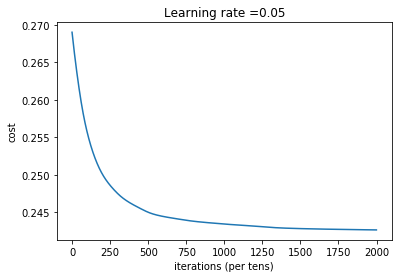

Test cost: 0.218024
Parameters have been trained!
Two Files are saved!
Files are saved!


In [45]:
#from IPython import get_ipython
#get_ipython().magic('reset -sf')

import numpy as np
#import DAE 


n_hidden = 64
corruption_level = 0.5
n_fold = 10
final_train_cost = []
final_test_cost = []
final_params = []
final_permutations = []

#data = np.genfromtxt("FilterRPTrain.csv",delimiter=',')
#Dev = np.genfromtxt("FilterRPDev.csv",delimiter=',')

output_data = data
input_data = data
#input_data = corruption(data, corruption_level)


n_samp, n_input = input_data.shape 

folds = KF(input_data, n_fold)

u"""
for tr, ts in folds: 
     parameters, tr_costs, ts_costs, permutation = DAE.model(input_data[tr, :], output_data[tr, :], input_data [ts, :], 
                                                            output_data[ts, :],  learning_rate = 0.01, 
                                                            num_epochs = 35, minibatch_size = 10,)
     final_params.append(parameters)
     final_train_cost.append(tr_costs)
     final_test_cost.append(ts_costs)
     final_permutations.append(permutation)
"""

from __future__ import absolute_import
Weight, bias, Hidden, Y_hat, tr_costs, ts_costs, permutation = model(input_data, output_data, Dev, 
                                                            Dev,  learning_rate = 0.05, 
                                                            num_epochs = 2000, minibatch_size = 10)
#final_params.append(parameters)
#final_train_cost.append(tr_costs)
#final_test_cost.append(ts_costs)
#final_permutations.append(permutation)




np.savetxt('WhNEPC.csv', Weight, fmt = '%.3f', delimiter = u',')
np.savetxt('ActhNEPC.csv', Hidden, fmt = '%.7f', delimiter = u',')
print "Two Files are saved!"

#np.savetxt('Predh.csv', Y_hat, fmt = '%.7f', delimiter = u',')

#np.savetxt('perm.txt', final_permutations, fmt = '%.7f', delimiter=',')

print "Files are saved!"


